In [ ]:
!pip install python-dotenv

In [ ]:
# import os
# from dotenv import load_dotenv

# # Load variables from .env into environment
# load_dotenv()

# # Access the API key
# AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")
# AZURE_KEY = os.getenv("AZURE_KEY")
# CHAT_DEPLOYMENT = os.getenv("CHAT_DEPLOYMENT")
# EMBED_DEPLOYMENT = os.getenv("EMBED_DEPLOYMENT")
# API_VERSION = os.getenv("API_VERSION")

In [25]:
print(AZURE_ENDPOINT)

None


In [ ]:
# API Testing
from openai import AzureOpenAI

AZURE_ENDPOINT = "https://assessment2025-resource.cognitiveservices.azure.com/"
AZURE_KEY = ""

CHAT_DEPLOYMENT = "gpt-4.1-mini"
EMBED_DEPLOYMENT = "text-embedding-ada-002"

client = AzureOpenAI(
    azure_endpoint=AZURE_ENDPOINT,
    api_key=AZURE_KEY,
    api_version="2025-01-01-preview"
)

# Test chat model
# test_response = client.chat.completions.create(
#     model=CHAT_DEPLOYMENT,
#     messages=[{"role": "user", "content": "Hello, what are you doing?"}],
#     max_tokens=50
# )

# print("Chat model Test:", test_response.choices[0].message.content)

In [6]:
# chunking
import tiktoken

with open("/content/liberation_war.txt") as f:
    liberation_war_content = f.read()

enc = tiktoken.get_encoding("cl100k_base")

def chunk_text(text, max_tokens=300):
    tokens = enc.encode(text)
    chunks = [enc.decode(tokens[i:i+max_tokens]) for i in range(0, len(tokens), max_tokens)]
    return chunks

chunks = chunk_text(liberation_war_content)
# print("Document Chunks:")
# for i, c in enumerate(chunks):
#     print(f"[{i}]: {c}")
# print(f"total chunks {i}")


In [7]:
# Embedding generation
import numpy as np

def embed(texts):
    res = client.embeddings.create(
        model=EMBED_DEPLOYMENT,
        input=texts
    )
    return np.array([d.embedding for d in res.data]).astype("float32")

embeddings = embed(chunks)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (5, 1536)


In [8]:
!pip install faiss-gpu-cu12 #faiss installing for GPU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 22.2 MB/s eta 0:00:00


In [9]:
# Converting to faiss vector DB
import faiss

dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)

print("FAISS index built. Number of vectors:", index.ntotal)

FAISS index built. Number of vectors: 5


In [10]:
# Simple retrive defining
def retrieve(query, top_k=2):
    """ Takes in user query and retrives similar chunk so that llm can take the
    chunks and get context which will also reduce hallucination
    """
    q_embed = embed([query])[0].reshape(1, -1)
    D, I = index.search(q_embed, top_k)
    return "\n".join([chunks[i] for i in I[0]])

# Test the retrieval
# query_test = "when liberation war happend"
# retrieved_text = retrieve(query_test)
# print("Retrieved text:\n", retrieved_text)

In [11]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [12]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [2]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.3 MB/s eta 0:00:00


In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(deployment_name="gpt-4.1-mini", openai_api_version="2025-01-01-preview", openai_api_key="EeK1erGEZA2b3ec4sDGzx3JvwUUvAv4YU6LbQ6gWJqKcJya33LK1JQQJ99BKACHYHv6XJ3w3AAAAACOGUL8L",temperature=0.2, azure_endpoint="https://assessment2025-resource.cognitiveservices.azure.com/")

In [13]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [14]:
tools = [retrieve]
llm_with_tool = llm.bind_tools(tools)

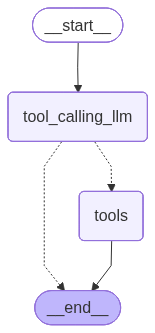

In [15]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
response=graph.invoke({"messages":"when did bangladesh gained independance?"})
response['messages'][-1].content

'Bangladesh gained independence on March 26, 1971.'

In [17]:
while True:
    query = input('Enter your question: ')
    if query in ['exit', 'q']: break
    response=graph.invoke({"messages":query})
    print(response['messages'][-1].content)

Enter your question: when did bangladesh gained independance?
Bangladesh gained independence on March 26, 1971.
Enter your question: what is the independance day of bangladesh?
The Independence Day of Bangladesh is celebrated on March 26th. It commemorates the country's declaration of independence from Pakistan in 1971.
Enter your question: q
